# GRIP June'21 - The Sparks Foundation

## Domain: Computer Vision & Internet of Things

## Author: Smriti Gupta

### Task 2: Color Identification in Images 

* Implement an image color detector which identifies all the colors in an image or video. 
* _LANGUAGE:_ Python
* _Images:_ https://bit.ly/3vhwV5S

### Importing Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76

%matplotlib inline

###  Reading Image and Checking Type and Shape of Image Data

The type of this input is <class 'numpy.ndarray'>
Shape: (952, 921, 3)


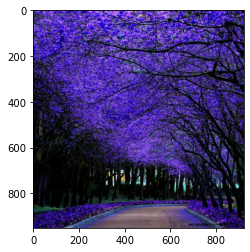

In [2]:
image = cv2.imread('Image2.jpg')
print("The type of this input is {}".format(type(image)))
print("Shape: {}".format(image.shape))
plt.imshow(image)

### Converting BGR-To-RGB

_**NOTE:**_ We can see that the above image has different colors as compared to the original image. This is because by default OpenCV reads the images in the color order "Blue-Green-RED" i.e. BGR. Thus, we need to convert it into "RED GREEN BLUE" i.e. RGB.

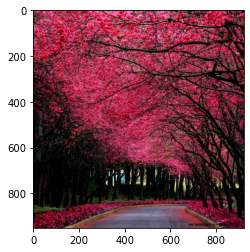

In [3]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

### Converting Image to GrayScale

Now we need to convert RGB image to grayscale becuase in RGB image we have 3 channel so computer need more time and memory to understand what's inside image but with grayscale we only left with 2-D array so it's easy for computer to understand.

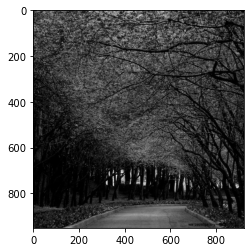

In [4]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

### Resizing Images

We need to resize the image to a certain size becuase we have images that are huge in size with different dimensions.

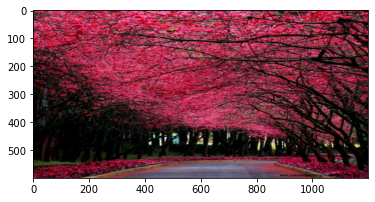

In [5]:
resized_image = cv2.resize(image, (1200, 600))
plt.imshow(resized_image)

# Color Identification

First, we will define a function that can give us the hex values of our the colors that we will identify.

In [6]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

KMeans expects flattened array as input during its fit method. Thus, we need to reshape the image using numpy. Then, we can apply KMeans to first fit and then predict on the image to get the results. Then, the cluster colors are identified an arranged in the correct order. We plot the colors as a pie chart. 

I have combined all the steps in two method.

### Defining method for getting Images and Conversion from BGR To RGB

In [7]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### Defining method along with K-Means Algorithm
First we need to resize data into same size, then converting into array on which I fitted the model.

In [8]:
def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    print(labels)
    
    counts = Counter(labels)
    
    center_colors = clf.cluster_centers_
    
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

### Calling above 2 Functions inside each other

[2 7 1 ... 3 3 3]


[array([160.58290184,  25.05362639,  55.2361951 ]),
 array([8.85900217, 6.83205474, 4.91811721]),
 array([217.08646508, 101.16205904, 136.45233981]),
 array([130.83241592,  60.82407046,  73.0914095 ]),
 array([98.3225797 , 31.65049733, 43.77700318]),
 array([50.3363155 , 25.49914795, 25.18751141]),
 array([122.14386398, 102.95859396, 116.9393005 ]),
 array([190.01221005,  59.30311655,  93.65991177])]

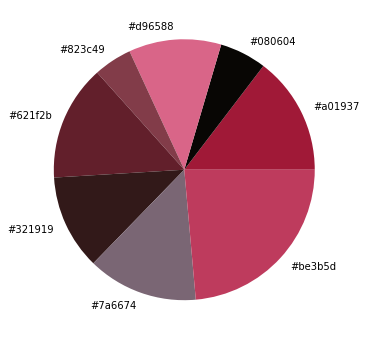

In [9]:
get_colors(get_image('Image2.jpg'), 8, True)

# Search Images using Color
From the model above, we can extract the major colors. This create the opportunity to search for images based on certain colors. We can select a color and if it's hex matches or is close to the hex of the major colors of the image, we say it's a match.

We first get all the images and store them in the "images" variable.

In [10]:
IMAGE_DIRECTORY = 'images'

COLORS = {'GREEN': [0, 128, 0],'BLUE': [0, 0, 128],'YELLOW': [255, 255, 0]}

images = []

for file in os.listdir(IMAGE_DIRECTORY):
    if not file.startswith('.'):
        images.append(get_image(os.path.join(IMAGE_DIRECTORY, file)))

### Visualization of Data

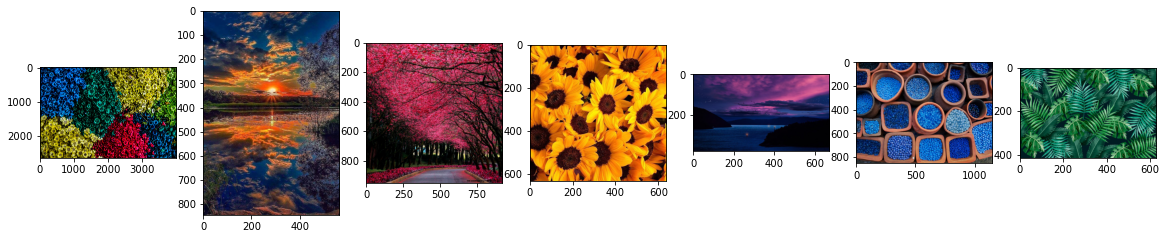

In [11]:
plt.figure(figsize=(20, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])

### Function for finding matches by using top 10 colors in images
We define the function below. We will try to match with the top 10 colors of the image. It is highly possible that there will be no extact match for the hex codes, thus we calculate the similarity between the chosen color and the colors of the image.

We keep a threshold value such that if the difference between the chosen color and any of the selected colors is less than that threshold, we declare it as a match.

Hex values or RGB values cannot be directly compared so we first convert them to a device independant and color uniform space. We use "RGB2LAB"  to convert the values and then find the difference using "deltaE_cie76". The method calculates the difference between all top 5 colors of the image and the selected color and if atleast one is below the threshold, we show the image.

In [12]:
def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    image_colors = get_colors(image, number_of_colors, False)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]])))

    select_image = False
    
    for i in range(number_of_colors):
        
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        diff = deltaE_cie76(selected_color, curr_color)
        
        if (diff < threshold):
            select_image = True
    
    return select_image

### Function for selection of images (Match/Mismatch)
We call the above method for all the images in our set and show relevant images out of the same that approximately match our selected color.

In [13]:
def show_selected_images(images, color, threshold, colors_to_match):
    index = 1
    
    for i in range(len(images)):
        selected = match_image_by_color(images[i],
                                        color,
                                        threshold,
                                        colors_to_match)
        
        if (selected):
            plt.subplot(1, 5, index)
            plt.imshow(images[i])
            plt.axis('off')
            
            index += 1

### Visualization

[0 0 0 ... 0 0 0]
[2 2 2 ... 4 4 4]
[2 2 4 ... 3 3 1]
[3 3 3 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 1 1 ... 4 1 1]
[4 4 4 ... 2 2 0]


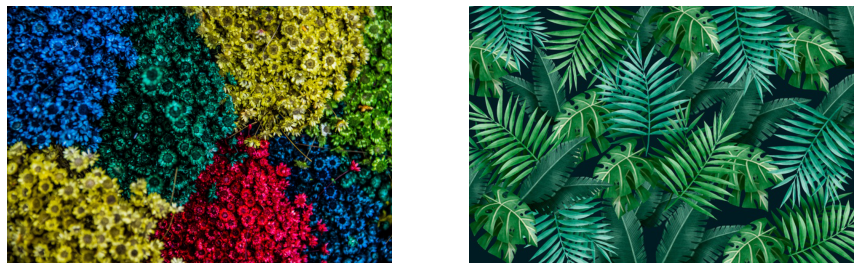

In [14]:
# Search for GREEN

plt.figure(figsize = (40, 20))
show_selected_images(images, COLORS['GREEN'], 60, 5)

[1 1 1 ... 1 1 1]
[0 0 0 ... 4 4 4]
[3 3 0 ... 1 1 4]
[1 1 1 ... 0 0 0]
[1 1 1 ... 1 1 1]
[2 0 0 ... 2 0 0]
[3 3 3 ... 4 4 1]


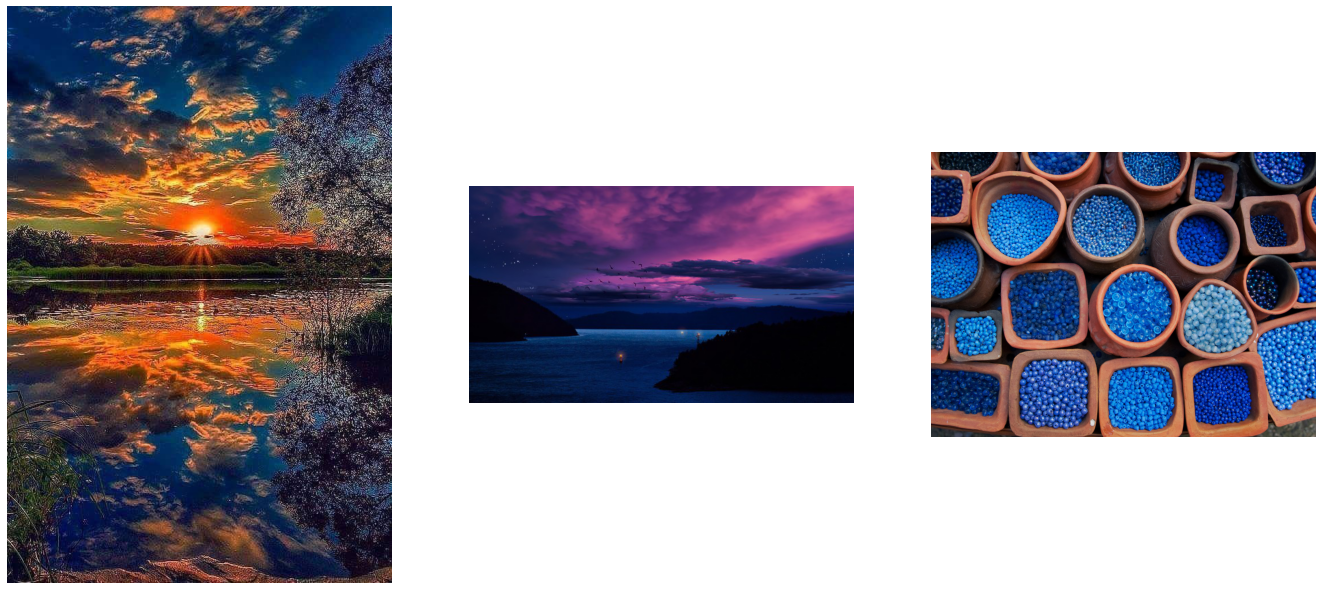

In [15]:
# Search for BLUE

plt.figure(figsize = (40, 20))
show_selected_images(images, COLORS['BLUE'], 60, 5)

[0 0 0 ... 0 0 0]
[0 0 0 ... 3 3 3]
[3 3 1 ... 0 2 2]
[1 1 1 ... 0 0 0]
[3 3 3 ... 3 3 3]
[4 1 1 ... 4 1 1]
[1 1 1 ... 2 2 3]


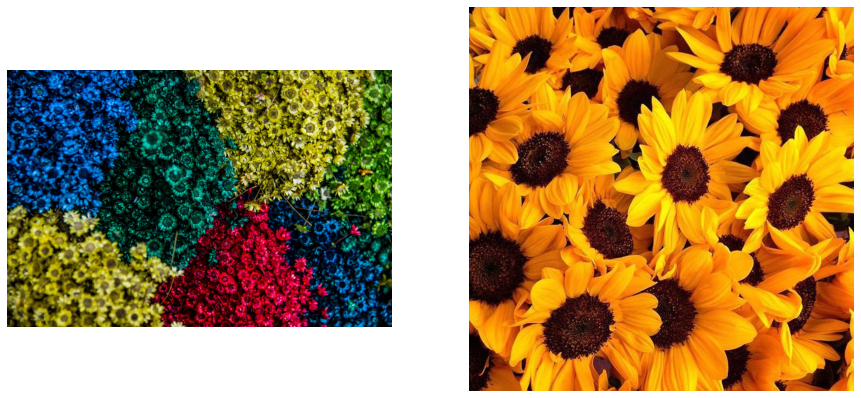

In [16]:
# Search for YELLOW

plt.figure(figsize = (40, 20))
show_selected_images(images, COLORS['YELLOW'], 60, 5)

## Conclusion
In this notebook, we used KMeans to extract majority colors from images. We then used the RGB Values of Colors to identify images from a collection that have that color in them.